In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from names import NamesDataset
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from util import get_accuracy, show_confusion

In [3]:
batch_size = 16
dataset = NamesDataset(directory='./data/names/', verbose=False)
train_loader, test_loader = dataset.build_data_loaders(batch_size)
X, y = iter(train_loader).next()
print("Names batch shape/type:", X.shape, "/", X.dtype)
print("Labels batch shape/type:", y.shape, "/", y.dtype)


Names batch shape/type: torch.Size([16, 19, 57]) / torch.float32
Labels batch shape/type: torch.Size([16]) / torch.float32


In [26]:
class NameClassifierConv(nn.Module):
    def __init__(self, in_channels, out_channels, n_outputs, dropout):
        super(NameClassifierConv, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_outputs = n_outputs
        self.dropout = dropout
        
        kernel_sizes = [1, 2, 3]
        n_kernels = len(kernel_sizes)
        self._convs = nn.ModuleList([
            nn.Conv1d(in_channels, out_channels, i) for i in kernel_sizes
        ])
        
        self.FC = nn.Linear(n_kernels * out_channels, n_outputs)
    
    def forward(self, X):
        # transforms X to dimensions: batch-size x in-channels x seq-len
        conv_in = X.transpose(1, 2)
        
        output = torch.cat(
            [conv(conv_in).max(dim=2)[0] for conv in self._convs], 
            dim=1
        )
        output = F.dropout(output, self.dropout, training=self.training)
        output = self.FC(output)
        
        return output.view(-1, self.n_outputs) # batch_size X n_output

In [27]:
def train(model, train_loader, test_loader, epochs, seq_length, num_chars, classes, lr=0.001):
    train_on_gpu = torch.cuda.is_available()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    num_classes = len(classes)
    all_losses = [100.0]
    all_train_acc = [1.0 / num_classes]
    all_test_acc = [1.0 / num_classes]

    all_losses = []
    all_train_acc = []
    all_test_acc = []


    for epoch in range(epochs):  # loop over the dataset multiple times
        train_running_loss = 0.0
        train_acc = 0.0
        model.train()

        # TRAINING ROUND
        for i, data in enumerate(train_loader):
             # zero the parameter gradients
            optimizer.zero_grad()

            # get the inputs
            inputs, labels = data
            if(train_on_gpu): inputs, labels = inputs.cuda(), labels.cuda()
            #inputs = inputs.view(-1, seq_length, num_chars) 

            # forward + backward + optimize
            outputs = model(inputs)

            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

            train_running_loss += loss.detach().item()
            train_acc += get_accuracy(outputs, labels, batch_size)

        model.eval()
        epoch_loss = min(100, 100 * train_running_loss / i)
        all_losses.append(epoch_loss)
        epoch_train_acc = train_acc / i
        all_train_acc.append(epoch_train_acc)

        test_acc = 0.0
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data
            if(train_on_gpu): inputs, labels = inputs.cuda(), labels.cuda()
            #inputs = inputs.view(-1, seq_length, num_chars) 
            outputs = model(inputs)
            test_acc += get_accuracy(outputs, labels, batch_size)
        epoch_test_acc = test_acc / i
        all_test_acc.append(epoch_test_acc)
        print(
            'Epoch:  %2d | Loss: %03.2f | Train Accuracy: %.2f | Test Accuracy: %.2f' %
            (epoch + 1, epoch_loss, epoch_train_acc, epoch_test_acc)
        )
    # Plot loss and accuracies:
    plt.figure()
    plt.plot([l for l in all_losses])
    plt.plot(all_test_acc)
    plt.plot(all_train_acc)
    plt.legend(['Average loss per epoch','Test Accuracy','Train Accuracy']);



In [30]:
seq_length = dataset.seq_length
num_chars = dataset.vocabulary_size
classes = dataset.classes
num_classes = dataset.num_classes
dropout = 0.82

classifier = NameClassifierConv(
    in_channels=num_chars, 
    out_channels=256, 
    n_outputs=num_classes,
    dropout=dropout
)
if(torch.cuda.is_available()): classifier.cuda()


print(classifier)

NameClassifierConv(
  (_convs): ModuleList(
    (0): Conv1d(57, 256, kernel_size=(1,), stride=(1,))
    (1): Conv1d(57, 256, kernel_size=(2,), stride=(1,))
    (2): Conv1d(57, 256, kernel_size=(3,), stride=(1,))
  )
  (FC): Linear(in_features=768, out_features=18, bias=True)
)


Epoch:   1 | Loss: 100.00 | Train Accuracy: 59.13 | Test Accuracy: 67.90
Epoch:   2 | Loss: 100.00 | Train Accuracy: 69.67 | Test Accuracy: 73.82
Epoch:   3 | Loss: 90.60 | Train Accuracy: 73.00 | Test Accuracy: 77.08
Epoch:   4 | Loss: 81.97 | Train Accuracy: 75.16 | Test Accuracy: 78.42
Epoch:   5 | Loss: 78.28 | Train Accuracy: 76.18 | Test Accuracy: 80.43
Epoch:   6 | Loss: 75.05 | Train Accuracy: 76.91 | Test Accuracy: 80.75
Epoch:   7 | Loss: 73.05 | Train Accuracy: 77.35 | Test Accuracy: 81.18
Epoch:   8 | Loss: 71.77 | Train Accuracy: 77.92 | Test Accuracy: 80.93
Epoch:   9 | Loss: 69.31 | Train Accuracy: 78.24 | Test Accuracy: 81.28
Epoch:  10 | Loss: 68.03 | Train Accuracy: 78.76 | Test Accuracy: 81.58
Epoch:  11 | Loss: 67.21 | Train Accuracy: 78.90 | Test Accuracy: 81.44
Epoch:  12 | Loss: 66.07 | Train Accuracy: 79.21 | Test Accuracy: 82.18
Epoch:  13 | Loss: 65.73 | Train Accuracy: 79.60 | Test Accuracy: 82.06
Epoch:  14 | Loss: 65.35 | Train Accuracy: 79.44 | Test Accura

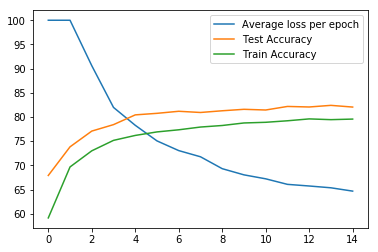

In [31]:
%%time
epochs=15
train(classifier, train_loader, test_loader, epochs, seq_length, num_chars, classes, lr=0.001)

In [ ]:
show_confusion(classifier, train_loader, seq_length, num_chars, classes)

In [ ]:
show_confusion(classifier, test_loader, seq_length, num_chars, classes)